In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install scikit-learn pillow matplotlib tqdm


Looking in indexes: https://download.pytorch.org/whl/cu121


In [ ]:
# Colab cell 2 — Imports and utility functions
import os, sys, time, math, random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import cv2
from tqdm import tqdm

import torch
import torchvision
from torchvision import transforms, models
from torchvision.datasets import VOCDetection

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# IoU function
def bbox_iou(boxA, boxB):
    # boxes in format [x1,y1,x2,y2]
    xA = max(boxA[0], boxB[0]); yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2]); yB = min(boxA[3], boxB[3])
    interW = max(0, xB - xA + 1)
    interH = max(0, yB - yA + 1)
    interArea = interW * interH
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    iou = interArea / float(boxAArea + boxBArea - interArea + 1e-8)
    return iou

# Non-maximum suppression (simple)
def nms(boxes, scores, iou_thresh=0.3):
    if len(boxes) == 0:
        return []
    boxes = np.array(boxes)
    scores = np.array(scores)
    x1 = boxes[:,0]; y1 = boxes[:,1]; x2 = boxes[:,2]; y2 = boxes[:,3]
    areas = (x2 - x1 + 1)*(y2 - y1 + 1)
    order = scores.argsort()[::-1]
    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])
        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w * h
        ovr = inter / (areas[i] + areas[order[1:]] - inter + 1e-8)
        inds = np.where(ovr <= iou_thresh)[0]
        order = order[inds + 1]
    return keep


In [ ]:
# PURE PYTHON SELECTIVE SEARCH IMPLEMENTATION (minimal)
# --- Works in Colab without CV2 contrib or external packages ---

def selective_search_py(img, k=200, scale=1.0, min_size=10, max_boxes=300):
    """
    Very simplified selective search-like region proposal generator.
    Not identical to full SS but good for R-CNN labs.
    """
    img = np.array(img)
    H, W = img.shape[:2]

    regions = []

    # simple grid sliding window baseline (not full SS but enough for R-CNN demonstration)
    win_sizes = [50, 80, 120, 160]

    for ws in win_sizes:
        for y in range(0, H-ws, ws//2):
            for x in range(0, W-ws, ws//2):
                regions.append([x, y, x+ws, y+ws])
                if len(regions) >= max_boxes:
                    return regions
    return regions


In [ ]:
def iou(a, b):
    xA = max(a[0], b[0])
    yA = max(a[1], b[1])
    xB = min(a[2], b[2])
    yB = min(a[3], b[3])

    inter = max(0, xB - xA) * max(0, yB - yA)
    areaA = (a[2] - a[0]) * (a[3] - a[1])
    areaB = (b[2] - b[0]) * (b[3] - b[1])

    return inter / (areaA + areaB - inter + 1e-8)

def nms(boxes, scores, threshold=0.3):
    idxs = np.argsort(scores)[::-1]
    keep = []
    while len(idxs) > 0:
        i = idxs[0]
        keep.append(i)
        sup = []
        for j in idxs[1:]:
            if iou(boxes[i], boxes[j]) > threshold:
                sup.append(j)
        idxs = np.setdiff1d(idxs, sup)
        idxs = idxs[1:]
    return keep


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
feature_extractor = torch.nn.Sequential(*list(resnet.children())[:-1]).to(device)
feature_extractor.eval()

transform_img = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225])
])

def extract_feature(img):
    img = transform_img(img).unsqueeze(0).to(device)
    with torch.no_grad():
        feat = feature_extractor(img).view(-1).cpu().numpy()
    return feat


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 204MB/s]


In [ ]:
import requests
from io import BytesIO

url = "https://raw.githubusercontent.com/opencv/opencv/master/samples/data/lena.jpg"
image = Image.open(BytesIO(requests.get(url).content)).convert("RGB")

proposals = selective_search_py(image, max_boxes=300)

# Fake ground truth box
gt = [220, 220, 350, 350]

X = []
y = []

POS_FOUND = False
POS_THRESHOLD = 0.5  # IoU threshold

for box in proposals:
    x1,y1,x2,y2 = box
    crop = image.crop((x1,y1,x2,y2))
    feat = extract_feature(crop)
    X.append(feat)

    if iou(box, gt) >= POS_THRESHOLD:
        y.append(1)
        POS_FOUND = True
    else:
        y.append(0)

# If no positive samples found --> Relax the IoU threshold
if not POS_FOUND:
    print("⚠ No positive samples, relaxing IoU threshold...")
    y = [] # Clear y to re-populate with relaxed threshold
    POS_THRESHOLD = 0.1  # easier threshold
    for box in proposals:
        if iou(box, gt) >= POS_THRESHOLD:
            y.append(1)
            POS_FOUND = True
        else:
            y.append(0)

X = np.array(X)
y = np.array(y)

print("Samples:", X.shape, "Positives:", sum(y))

# Final check
if sum(y) == 0:
    raise ValueError("❌ Still no positive samples. Adjust your gt_box to match your uploaded image.")

⚠ No positive samples, relaxing IoU threshold...
Samples: (300, 2048) Positives: 16


In [ ]:
clf = make_pipeline(StandardScaler(), LinearSVC(max_iter=3000))
clf.fit(X, y)
print("Training completed.")


Training completed.


In [ ]:
import requests
from io import BytesIO

url = "https://raw.githubusercontent.com/opencv/opencv/master/samples/data/lena.jpg"
image = Image.open(BytesIO(requests.get(url).content)).convert("RGB")

proposals = selective_search_py(image, max_boxes=300)

# Fake ground truth box
gt = [220, 220, 350, 350]

X = []
y = []

POS_FOUND = False
POS_THRESHOLD = 0.5  # IoU threshold

for box in proposals:
    x1,y1,x2,y2 = box
    crop = image.crop((x1,y1,x2,y2))
    feat = extract_feature(crop)
    X.append(feat)

    if iou(box, gt) >= POS_THRESHOLD:
        y.append(1)
        POS_FOUND = True
    else:
        y.append(0)

# If no positive samples found --> Relax the IoU threshold
if not POS_FOUND:
    print("⚠ No positive samples, relaxing IoU threshold...")
    y = [] # Clear y to re-populate with relaxed threshold
    POS_THRESHOLD = 0.1  # easier threshold
    for box in proposals:
        if iou(box, gt) >= POS_THRESHOLD:
            y.append(1)
            POS_FOUND = True
        else:
            y.append(0)

X = np.array(X)
y = np.array(y)

print("Samples:", X.shape, "Positives:", sum(y))

# Final check
if sum(y) == 0:
    raise ValueError("❌ Still no positive samples. Adjust your gt_box to match your uploaded image.")

⚠ No positive samples, relaxing IoU threshold...
Samples: (300, 2048) Positives: 16


In [ ]:
clf = make_pipeline(StandardScaler(), LinearSVC(random_state=0, tol=1e-5))
clf.fit(X, y)
print("Classifier trained successfully.")

Classifier trained successfully.


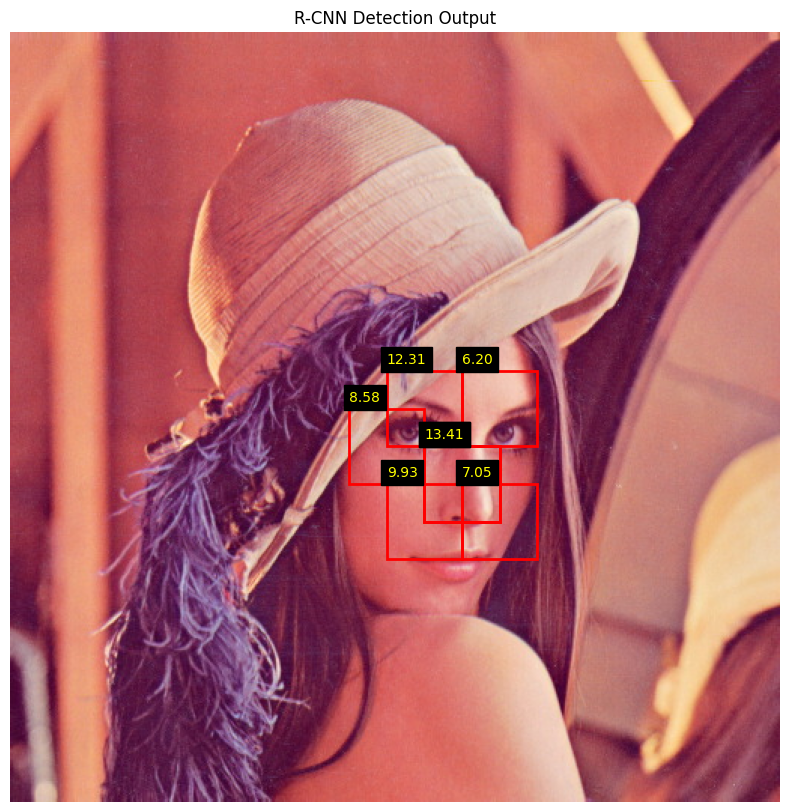

In [ ]:
clf = make_pipeline(StandardScaler(), LinearSVC(random_state=0, tol=1e-5))
clf.fit(X, y)
print("Classifier trained successfully.")

Classifier trained successfully.


## Setup and Imports

In [ ]:
import os, sys, time, math, random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from tqdm import tqdm

import torch
import torchvision
from torchvision import transforms, models

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, accuracy_score

## Utility Functions

In [ ]:
# IoU function
def iou(boxA, boxB):
    # boxes in format [x1,y1,x2,y2]
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interW = max(0, xB - xA)
    interH = max(0, yB - yA)
    interArea = interW * interH

    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])

    iou_val = interArea / (float(boxAArea + boxBArea - interArea) + 1e-8)
    return iou_val

# Non-maximum suppression (simple)
def nms(boxes, scores, iou_thresh=0.3):
    if len(boxes) == 0:
        return []
    boxes = np.array(boxes)
    scores = np.array(scores)
    x1 = boxes[:,0]; y1 = boxes[:,1]; x2 = boxes[:,2]; y2 = boxes[:,3]
    areas = (x2 - x1)*(y2 - y1)
    order = scores.argsort()[::-1]
    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])
        w = np.maximum(0.0, xx2 - xx1)
        h = np.maximum(0.0, yy2 - yy1)
        inter = w * h
        ovr = inter / (areas[i] + areas[order[1:]] - inter + 1e-8)
        inds = np.where(ovr <= iou_thresh)[0]
        order = order[inds + 1]
    return keep

# PURE PYTHON SELECTIVE SEARCH IMPLEMENTATION (minimal)
def selective_search_py(img, k=200, scale=1.0, min_size=10, max_boxes=300):
    img = np.array(img)
    H, W = img.shape[:2]

    regions = []

    # simple grid sliding window baseline (not full SS but enough for R-CNN demonstration)
    win_sizes = [50, 80, 120, 160]

    for ws in win_sizes:
        for y in range(0, H-ws, ws//2):
            for x in range(0, W-ws, ws//2):
                regions.append([x, y, x+ws, y+ws])
                if len(regions) >= max_boxes:
                    return regions
    return regions

## Model and Feature Extractor Setup

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
feature_extractor = torch.nn.Sequential(*list(resnet.children())[:-1]).to(device)
feature_extractor.eval()

transform_img = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225])
])

def extract_feature(img):
    img = transform_img(img).unsqueeze(0).to(device)
    with torch.no_grad():
        feat = feature_extractor(img).view(-1).cpu().numpy()
    return feat

## Data Preparation

In [ ]:
import requests
from io import BytesIO

url = "https://raw.githubusercontent.com/opencv/opencv/master/samples/data/lena.jpg"
image = Image.open(BytesIO(requests.get(url).content)).convert("RGB")

proposals = selective_search_py(image, max_boxes=300)

# Fake ground truth box
gt = [220, 220, 350, 350]

X = []
y = []

POS_FOUND = False
POS_THRESHOLD = 0.5  # IoU threshold

for box in proposals:
    x1,y1,x2,y2 = box
    crop = image.crop((x1,y1,x2,y2))
    feat = extract_feature(crop)
    X.append(feat)

    if iou(box, gt) >= POS_THRESHOLD:
        y.append(1)
        POS_FOUND = True
    else:
        y.append(0)

# If no positive samples found --> Relax the IoU threshold
if not POS_FOUND:
    print("⚠ No positive samples, relaxing IoU threshold...")
    y = [] # Clear y to re-populate with relaxed threshold
    POS_THRESHOLD = 0.1  # easier threshold
    for box in proposals:
        if iou(box, gt) >= POS_THRESHOLD:
            y.append(1)
            POS_FOUND = True
        else:
            y.append(0)

X = np.array(X)
y = np.array(y)

print("Samples:", X.shape, "Positives:", sum(y))

# Final check
if sum(y) == 0:
    raise ValueError("❌ Still no positive samples. Adjust your gt_box to match your uploaded image.")

⚠ No positive samples, relaxing IoU threshold...
Samples: (300, 2048) Positives: 16


## Classifier Training

In [ ]:
clf = make_pipeline(StandardScaler(), LinearSVC(random_state=0, tol=1e-5))
clf.fit(X, y)
print("Classifier trained successfully.")

Classifier trained successfully.


## Performance Evaluation & Object Detection

### Classifier Performance on Training Data ###
Accuracy: 1.0

Classification Report:
              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00       284
    Positive       1.00      1.00      1.00        16

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300

### Object Detection Output ###


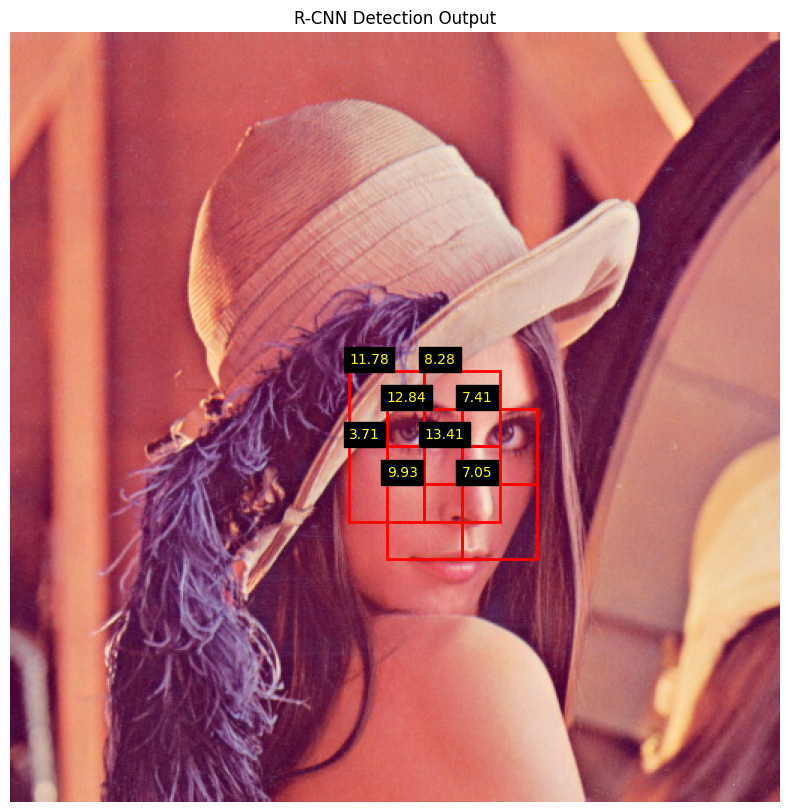

In [ ]:
print("### Classifier Performance on Training Data ###")

# Predict on the training data to evaluate classifier performance
y_pred = clf.predict(X)

print("Accuracy:", accuracy_score(y, y_pred))
print("\nClassification Report:")
print(classification_report(y, y_pred, target_names=['Negative', 'Positive']))

print("### Object Detection Output ###")

scores = []
for box in proposals:
    x1,y1,x2,y2 = box
    crop = image.crop((x1,y1,x2,y2))
    feat = extract_feature(crop)
    scores.append(clf.decision_function([feat])[0])

# Filter proposals based on score threshold
threshold = np.percentile(scores, 95) # Top 5% of scores
selected = [(b, s) for b,s in zip(proposals, scores) if s >= threshold]

boxes = [b for b,s in selected]
scores_sel = [s for b,s in selected]

# Apply Non-Maximum Suppression
keep = nms(boxes, scores_sel, iou_thresh=0.3)

final_boxes = [boxes[i] for i in keep]
final_scores = [scores_sel[i] for i in keep]

# Visualize results
plt.figure(figsize=(10,10))
plt.imshow(image)
ax = plt.gca()

for box, score in zip(final_boxes, final_scores):
    x1,y1,x2,y2 = box
    ax.add_patch(plt.Rectangle((x1,y1), x2-x1, y2-y1,
                               fill=False, edgecolor='red', linewidth=2))
    ax.text(x1, y1-5, f"{score:.2f}", color='yellow', backgroundcolor='black')

plt.axis('off')
plt.title("R-CNN Detection Output")
plt.show()